PyTorch version: 2.5.1+cu121
GPU available: True
GPU device: NVIDIA GeForce GTX 1650

Loading power data...
Power data shape: (105120, 2)
        LocalTime  Power(MW)
0  01/01/06 00:00        0.0
1  01/01/06 00:05        0.0
2  01/01/06 00:10        0.0
3  01/01/06 00:15        0.0
4  01/01/06 00:20        0.0

Loading enhanced weather data...
Weather data shape: (17520, 14)
        DateTime      Date  TempF  Humidity  SurfaceAlbedo  ClearskyDHI  PrecipitableWater    AOD   CloudTypeCategory  WindSpeed  Ozone  Hour  Minute  HrsDaylight
0  1/1/2006 0:00  1/1/2006  32.90     96.59           0.11            0                1.2  0.199  Super-Cooled Water        1.8  0.340     0       0          9.0
1  1/1/2006 0:30  1/1/2006  32.54     98.00           0.11            0                1.2  0.199  Super-Cooled Water        1.7  0.344     0      30          9.0
2  1/1/2006 1:00  1/1/2006  32.18     96.76           0.11            0                1.1  0.211  Super-Cooled Water        1.7  0.3

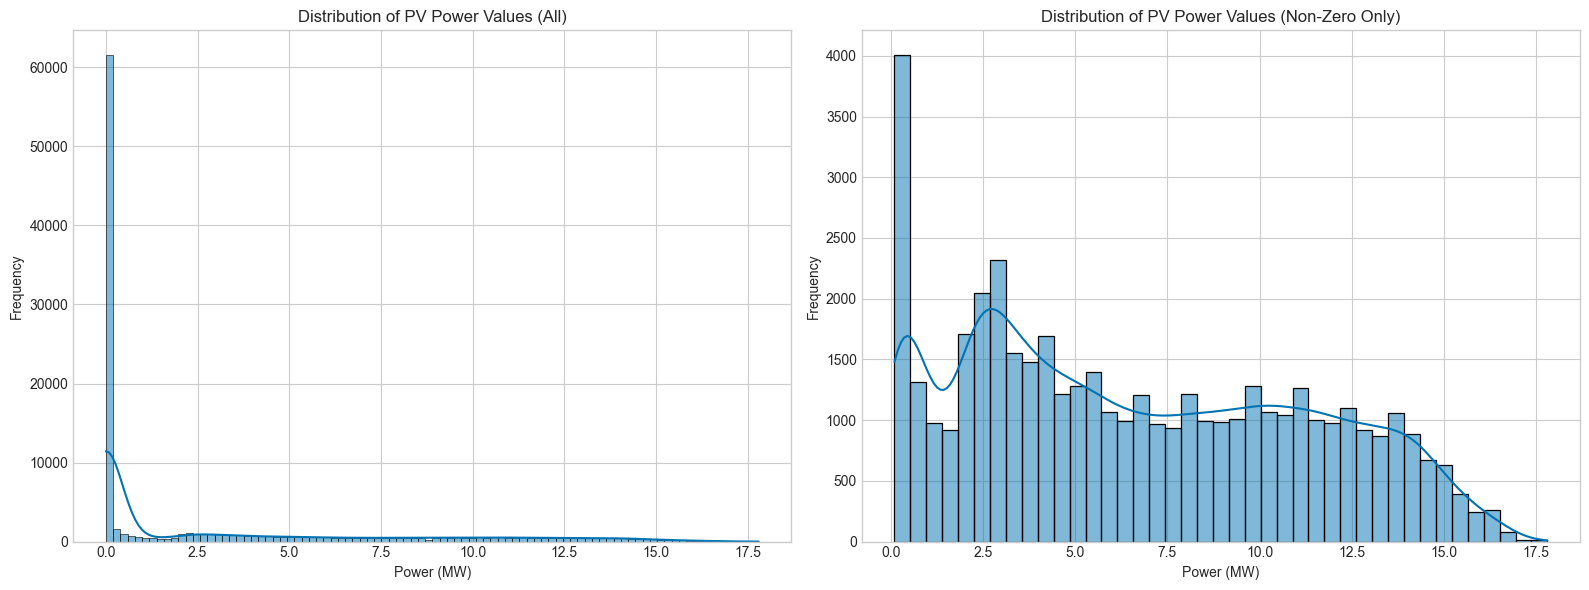

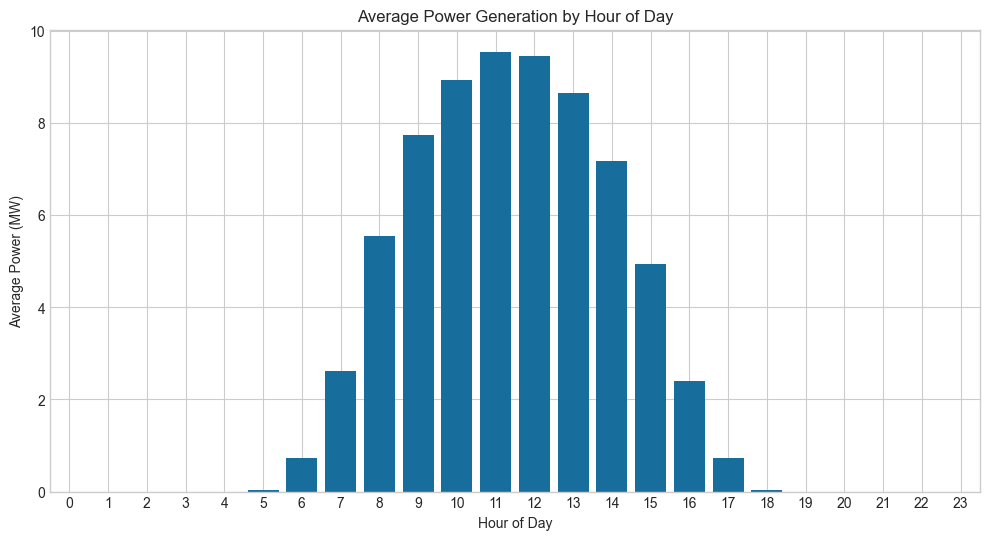

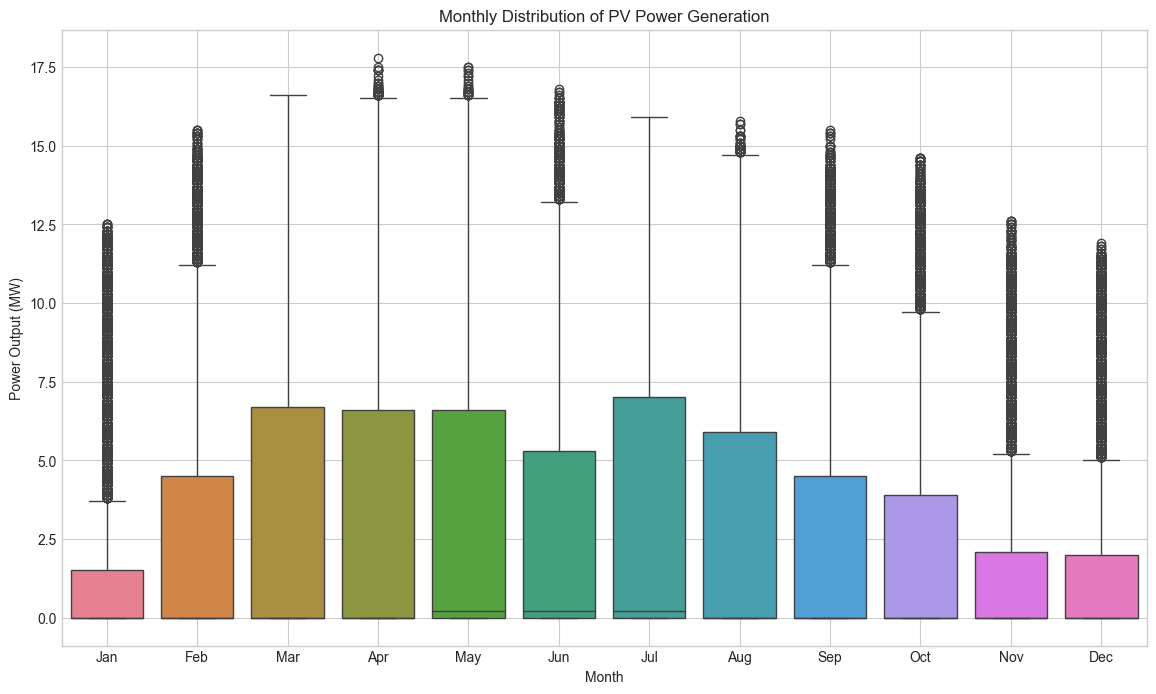


Resampling power data to 30-minute intervals...
Resampled power data (30-min):
             DateTime  Power(MW)
0 2006-01-01 00:00:00        0.0
1 2006-01-01 00:30:00        0.0
2 2006-01-01 01:00:00        0.0
3 2006-01-01 01:30:00        0.0
4 2006-01-01 02:00:00        0.0

Merged data shape: (17520, 15)

Final data format:
             DateTime  Power  TempC  Humidity  HrsDaylight  Albedo  ClearDHI  PrecipitableWater    AOD           CloudType  WindSpeed  Ozone
0 2006-01-01 00:00:00    0.0    0.5     96.59          9.0    0.11         0                1.2  0.199  Super-Cooled Water        1.8  0.340
1 2006-01-01 00:30:00    0.0    0.3     98.00          9.0    0.11         0                1.2  0.199  Super-Cooled Water        1.7  0.344
2 2006-01-01 01:00:00    0.0    0.1     96.76          9.0    0.11         0                1.1  0.211  Super-Cooled Water        1.7  0.348
3 2006-01-01 01:30:00    0.0   -0.1     98.17          9.0    0.11         0                1.1  0.211  Su

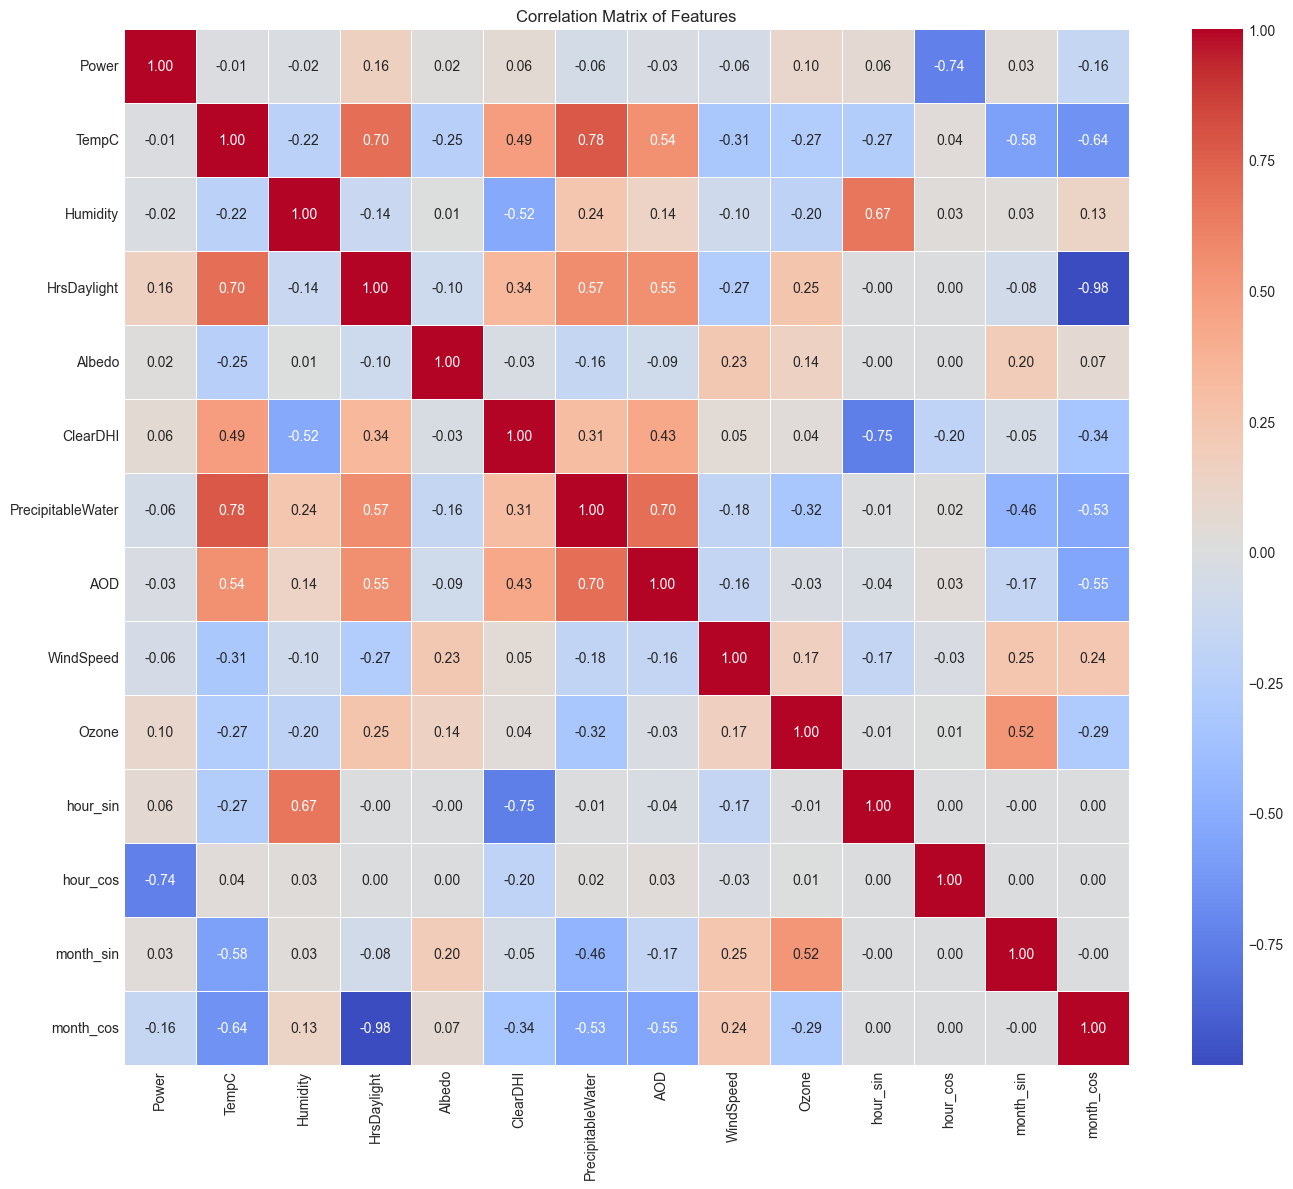


Training data: (11664, 25) rows from 2006-01-01 00:00:00 to 2006-08-31 23:30:00
Validation data: (1393, 25) rows from 2006-09-01 00:00:00 to 2006-09-30 00:00:00
Testing data: (4415, 25) rows from 2006-10-01 00:30:00 to 2006-12-31 23:30:00


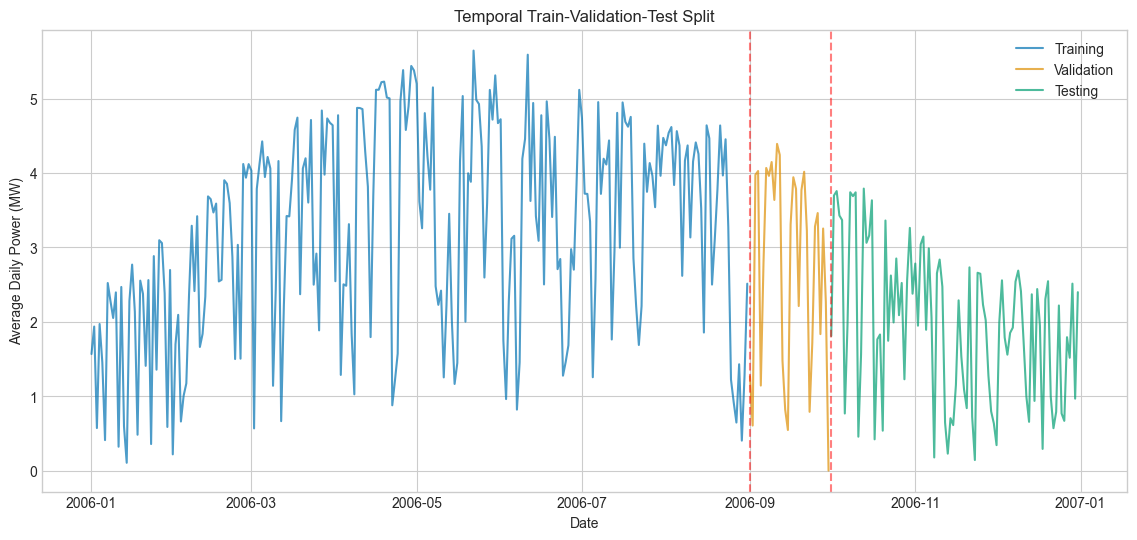


Scaled data (first few rows):
   Power     TempC  Humidity  HrsDaylight    Albedo  ClearDHI  PrecipitableWater       AOD  WindSpeed     Ozone
0    0.0  0.252174  0.952374          0.0  0.014286       0.0           0.172414  0.115861   0.220779  0.338843
1    0.0  0.247826  0.972067          0.0  0.014286       0.0           0.172414  0.115861   0.207792  0.355372
2    0.0  0.243478  0.954749          0.0  0.014286       0.0           0.155172  0.123296   0.207792  0.371901
3    0.0  0.239130  0.974441          0.0  0.014286       0.0           0.155172  0.123296   0.207792  0.388430
4    0.0  0.234783  0.950000          0.0  0.014286       0.0           0.155172  0.115242   0.194805  0.404959

Filtering to daylight hours...
Daylight hours data shapes:
Training: (6804, 25) rows
Validation: (812, 25) rows
Testing: (2576, 25) rows

Creating training sequences...
Creating sequences with 6804 rows of data
Will create approximately 6796 sequences
Using 23 features: ['Power', 'TempC', 'Humid

In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os
import warnings
import joblib

# Check for PyTorch availability
try:
    import torch
    pytorch_available = True
    print("PyTorch version:", torch.__version__)
    print("GPU available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU device:", torch.cuda.get_device_name(0))
    torch.manual_seed(42)  # For reproducibility
except ImportError:
    pytorch_available = False
    print("PyTorch not available. No GPU detection performed.")

# Set random seeds for reproducibility
np.random.seed(42)
warnings.filterwarnings('ignore')

# Enable better graphics
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.grid'] = True
sns.set_palette('colorblind')

# Create output directories
for folder in ['output', 'models', 'figures']:
    os.makedirs(folder, exist_ok=True)

# %% [markdown]
# ## 1. Load and Process the Data

# %%
# Load the power data
print("\nLoading power data...")
power_data = pd.read_csv('Actual_40.85_-73.85_2006_DPV_21MW_5_Min.csv')
print("Power data shape:", power_data.shape)
print(power_data.head())

# Convert timestamp and set as index
power_data['LocalTime'] = pd.to_datetime(power_data['LocalTime'], format='%m/%d/%y %H:%M')
power_data = power_data.set_index('LocalTime')
power_data = power_data.sort_index()

# Load the enhanced weather data
print("\nLoading enhanced weather data...")
weather_data = pd.read_csv('weather_2006_enhanced_30min.csv')
print("Weather data shape:", weather_data.shape)
print(weather_data.head())

# Check the columns in the weather data
print("\nWeather data columns:")
print(weather_data.columns.tolist())

# Convert DateTime to proper format
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data = weather_data.sort_values('DateTime')

# %% [markdown]
# ## 2. Data Exploration and Visualization

# %%
# Plot distribution of power values
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(power_data['Power(MW)'], kde=True)
plt.title('Distribution of PV Power Values (All)')
plt.xlabel('Power (MW)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(power_data[power_data['Power(MW)'] > 0]['Power(MW)'], kde=True)
plt.title('Distribution of PV Power Values (Non-Zero Only)')
plt.xlabel('Power (MW)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('figures/power_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze average power by hour to identify daylight hours
hourly_avg_power = power_data.groupby(power_data.index.hour)['Power(MW)'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_avg_power.index, y=hourly_avg_power.values)
plt.title('Average Power Generation by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (MW)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.savefig('figures/avg_power_by_hour.png', dpi=300, bbox_inches='tight')
plt.show()

# Define daylight hours based on the visualization
daylight_hours = list(range(6, 20))  # 6 AM to 8 PM

# Monthly distribution of PV power
plt.figure(figsize=(14, 8))
monthly_data = power_data.groupby(power_data.index.month)['Power(MW)'].apply(list)
sns.boxplot(data=[monthly_data[i] for i in range(1, 13)])
plt.title('Monthly Distribution of PV Power Generation')
plt.xlabel('Month')
plt.ylabel('Power Output (MW)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.savefig('figures/monthly_power_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 3. Process 30-Minute Data and Merge

# %%
# Resample 5-minute power data to 30-minute intervals
print("\nResampling power data to 30-minute intervals...")
power_30min = power_data.resample('30min').mean()
power_30min = power_30min.reset_index()
power_30min = power_30min.rename(columns={'LocalTime': 'DateTime'})
print("Resampled power data (30-min):")
print(power_30min.head())

# Merge the datasets on DateTime
merged_data = pd.merge(power_30min, weather_data, on='DateTime', how='inner')
print("\nMerged data shape:", merged_data.shape)

# Convert temperature from Fahrenheit to Celsius
merged_data['TempC'] = (merged_data['TempF'] - 32) * 5/9

# Select and rename final columns
final_data = merged_data[['DateTime', 'Power(MW)', 'TempC', 'Humidity', 
                          'HrsDaylight', 'SurfaceAlbedo', 'ClearskyDHI', 
                          'PrecipitableWater', 'AOD', 'CloudTypeCategory', 
                          'WindSpeed', 'Ozone']]

# Rename columns for clarity
final_data = final_data.rename(columns={
    'Power(MW)': 'Power',
    'SurfaceAlbedo': 'Albedo',
    'ClearskyDHI': 'ClearDHI',
    'CloudTypeCategory': 'CloudType'  # Rename to just CloudType
})

print("\nFinal data format:")
print(final_data.head())

# %% [markdown]
# ## 4. Feature Engineering

# %%
# Add time components for feature engineering
final_data['Hour'] = final_data['DateTime'].dt.hour
final_data['Minute'] = final_data['DateTime'].dt.minute
final_data['Month'] = final_data['DateTime'].dt.month
final_data['Day'] = final_data['DateTime'].dt.day
final_data['DayOfYear'] = final_data['DateTime'].dt.dayofyear
final_data['DayOfWeek'] = final_data['DateTime'].dt.dayofweek
final_data['is_daylight'] = final_data['Hour'].isin(daylight_hours)

# Add cyclical time features
print("\nAdding cyclical time features...")
# Hour of day (0-23.5 in 30-min increments)
final_data['hour_sin'] = np.sin(2 * np.pi * (final_data['Hour'] + final_data['Minute']/60) / 24)
final_data['hour_cos'] = np.cos(2 * np.pi * (final_data['Hour'] + final_data['Minute']/60) / 24)

# Month of year (1-12)
final_data['month_sin'] = np.sin(2 * np.pi * final_data['Month'] / 12)
final_data['month_cos'] = np.cos(2 * np.pi * final_data['Month'] / 12)

# Day of year (1-365)
final_data['dayofyear_sin'] = np.sin(2 * np.pi * final_data['DayOfYear'] / 365)
final_data['dayofyear_cos'] = np.cos(2 * np.pi * final_data['DayOfYear'] / 365)

# %% [markdown]
# ## 5. Correlation Analysis

# %%
# Calculate correlation between features
correlation_columns = ['Power', 'TempC', 'Humidity', 'HrsDaylight', 
                       'Albedo', 'ClearDHI', 'PrecipitableWater', 'AOD',
                       'WindSpeed', 'Ozone', 'hour_sin', 'hour_cos', 
                       'month_sin', 'month_cos']

# Calculate correlation matrix
corr_matrix = final_data[correlation_columns].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.savefig('figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 6. Feature Scaling and Train-Test Split

# %%
# Define the split points
train_end = '2006-09-30'
val_start = '2006-09-01'
val_end = train_end
test_start = '2006-10-01'

# Create the splits
train_data = final_data[final_data['DateTime'] < pd.to_datetime(val_start)].copy()
val_data = final_data[(final_data['DateTime'] >= pd.to_datetime(val_start)) & 
                      (final_data['DateTime'] <= pd.to_datetime(val_end))].copy()
test_data = final_data[final_data['DateTime'] > pd.to_datetime(test_start)].copy()

print(f"\nTraining data: {train_data.shape} rows from {train_data['DateTime'].min()} to {train_data['DateTime'].max()}")
print(f"Validation data: {val_data.shape} rows from {val_data['DateTime'].min()} to {val_data['DateTime'].max()}")
print(f"Testing data: {test_data.shape} rows from {test_data['DateTime'].min()} to {test_data['DateTime'].max()}")

# Visualize the split
plt.figure(figsize=(14, 6))
# Resample to daily for better visualization
train_daily = train_data.groupby(train_data['DateTime'].dt.date)['Power'].mean()
val_daily = val_data.groupby(val_data['DateTime'].dt.date)['Power'].mean()
test_daily = test_data.groupby(test_data['DateTime'].dt.date)['Power'].mean()

# Convert index to datetime for plotting
train_idx = pd.to_datetime(train_daily.index)
val_idx = pd.to_datetime(val_daily.index)
test_idx = pd.to_datetime(test_daily.index)

plt.plot(train_idx, train_daily.values, label='Training', alpha=0.7)
plt.plot(val_idx, val_daily.values, label='Validation', alpha=0.7)
plt.plot(test_idx, test_daily.values, label='Testing', alpha=0.7)
plt.axvline(x=pd.to_datetime(val_start), color='r', linestyle='--', alpha=0.5)
plt.axvline(x=pd.to_datetime(test_start), color='r', linestyle='--', alpha=0.5)
plt.title('Temporal Train-Validation-Test Split')
plt.xlabel('Date')
plt.ylabel('Average Daily Power (MW)')
plt.legend()
plt.savefig('figures/train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 7. Feature Normalization

# %%
# Select features for scaling
features_to_scale = [
    'Power', 'TempC', 'Humidity', 'HrsDaylight', 'Albedo', 
    'ClearDHI', 'PrecipitableWater', 'AOD', 
    'WindSpeed', 'Ozone'
]

# Create a copy of the data for scaling
scaled_data = final_data.copy()

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on training data only
scaler.fit(train_data[features_to_scale])

# Transform all datasets
scaled_train = train_data.copy()
scaled_val = val_data.copy()
scaled_test = test_data.copy()

scaled_train[features_to_scale] = scaler.transform(scaled_train[features_to_scale])
scaled_val[features_to_scale] = scaler.transform(scaled_val[features_to_scale])
scaled_test[features_to_scale] = scaler.transform(scaled_test[features_to_scale])

# Combine for a complete scaled dataset
scaled_data = pd.concat([scaled_train, scaled_val, scaled_test]).sort_values('DateTime')

# Show the scaled data
print("\nScaled data (first few rows):")
print(scaled_data[features_to_scale].head())

# Save the scaler for later use
joblib.dump(scaler, 'models/feature_scaler.pkl')

# %% [markdown]
# ## 8. Create LSTM Sequences

# %%
# Define the sequence preparation function
def create_sequences(data, target_col, seq_length=16, pred_horizon=1, step=1):
    """
    Create sequences for time series forecasting.
    
    Parameters:
        data: DataFrame containing the time series data
        target_col: Name of the column to predict
        seq_length: Number of time steps in each sequence (lookback)
        pred_horizon: How many steps ahead to predict
        step: Sampling rate for sequences (1 = use every time step)
        
    Returns:
        X: Input sequences [samples, time steps, features]
        y: Target values [samples, target dimension]
    """
    print(f"Creating sequences with {len(data)} rows of data")
    
    # Initialize empty lists for sequences and targets
    sequences = []
    targets = []
    
    # Create sequences
    total_steps = (len(data) - seq_length - pred_horizon + 1) // step
    print(f"Will create approximately {total_steps} sequences")
    
    # Define feature columns to use (all except DateTime and categorical columns)
    feature_cols = [col for col in data.columns if col != 'DateTime' and col != 'CloudType' 
                    and data[col].dtype != 'object']
    print(f"Using {len(feature_cols)} features: {feature_cols[:5]}...")
    
    # Convert to numpy array for faster processing
    data_array = data[feature_cols].values
    
    # Find index of target column
    target_idx = feature_cols.index(target_col)
    
    for i in range(0, len(data) - seq_length - pred_horizon + 1, step):
        if i % (total_steps // 10 + 1) == 0:  # Print progress at ~10% intervals
            print(f"Creating sequence {i}/{total_steps} ({i/total_steps*100:.1f}%)")
            
        # Get sequence
        seq = data_array[i:i+seq_length]
        
        # Get target
        target = data_array[i+seq_length+pred_horizon-1, target_idx]
        
        sequences.append(seq)
        targets.append(target)
    
    # Convert lists to numpy arrays
    X = np.array(sequences)
    y = np.array(targets)
    print(f"Created sequences with shape {X.shape} and targets with shape {y.shape}")
    
    return X, y, feature_cols

# Filter to only include daylight hours for training
print("\nFiltering to daylight hours...")
train_daylight = scaled_train[scaled_train['is_daylight'] == True].copy()
val_daylight = scaled_val[scaled_val['is_daylight'] == True].copy()
test_daylight = scaled_test[scaled_test['is_daylight'] == True].copy()

print(f"Daylight hours data shapes:")
print(f"Training: {train_daylight.shape} rows")
print(f"Validation: {val_daylight.shape} rows")
print(f"Testing: {test_daylight.shape} rows")

# Try to create sequences with error handling
try:
    # Use a shorter sequence length
    seq_length = 8  # 8 time steps (4 hours with 30-min data)
    
    print("\nCreating training sequences...")
    X_train, y_train, feature_cols = create_sequences(train_daylight, 'Power', seq_length=seq_length)
    
    print("\nCreating validation sequences...")
    X_val, y_val, _ = create_sequences(val_daylight, 'Power', seq_length=seq_length)
    
    print("\nCreating test sequences...")
    X_test, y_test, _ = create_sequences(test_daylight, 'Power', seq_length=seq_length)
    
    print("\nSequence creation completed successfully!")
    
    # Print final dimensions
    print(f"\nFinal sequence dimensions:")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    
    # Save the preprocessed sequences
    np.save('models/X_train.npy', X_train)
    np.save('models/y_train.npy', y_train)
    np.save('models/X_val.npy', X_val)
    np.save('models/y_val.npy', y_val)
    np.save('models/X_test.npy', X_test)
    np.save('models/y_test.npy', y_test)
    
    # Save the feature columns for reference
    with open('models/feature_columns.txt', 'w') as f:
        for col in feature_cols:
            f.write(f"{col}\n")
    
except Exception as e:
    print(f"\nError creating sequences: {str(e)}")
    print("You can adjust the sequence length or data filtering to resolve this issue.")

# %% [markdown]
# ## 9. Save Processed Data

# %%
# Save the processed data
print("\nSaving processed data...")
final_data.to_csv('output/solar_data_30min.csv', index=False)
train_data.to_csv('output/train_data_30min.csv', index=False)
val_data.to_csv('output/val_data_30min.csv', index=False)
test_data.to_csv('output/test_data_30min.csv', index=False)

# Save scaled data
scaled_data.to_csv('output/solar_data_30min_scaled.csv', index=False)
scaled_train.to_csv('output/train_data_30min_scaled.csv', index=False)
scaled_val.to_csv('output/val_data_30min_scaled.csv', index=False)
scaled_test.to_csv('output/test_data_30min_scaled.csv', index=False)

print("\nPreprocessing complete! All files and visualizations have been saved.")
print("\nTraining data is now ready for LSTM or other models.")